# Analysis of Croatia vs Spain games across 2 Euro tournament

- [Player passes](#playerpasses)
- [Passing network](#network)
- [Takeons](#takeons)
- [Possession](#possession)
- [Defensive actions](#defensive)
- [Shots](#shots)


References :

- https://www.dzialowski.eu/football-data-visualisations/
- https://github.com/eddwebster/football_analytics/blob/master/notebooks/5_data_analysis_and_projects/england_euro_2020/StatsBomb%20EURO%202020%20Data%20Visualisation.ipynb


In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mplsoccer import Pitch, VerticalPitch
import requests
from bs4 import BeautifulSoup
import matplotlib.patches as mpatches
import matplotlib.colors as mcol
from matplotlib.lines import Line2D
from pitch_fig import beauty_pitch
pd.set_option('display.max_columns', None)

import warnings

# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")


In [2]:
# Fonction to extract Json from Html 

def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [3]:
# fonctions to extract stats from the event df

def pass_angle(qualifier):
    if len(qualifier) > 0:
        for elt in qualifier:
            if elt["type"]["displayName"]=="Angle":
                value = elt["value"]
                break
            else:
                value = np.NaN
    else:
        value = np.NaN
        
    return value

def pass_length(qualifier):
    if len(qualifier) > 0:
        for elt in qualifier:
            if elt["type"]["displayName"]=="Length":
                value = elt["value"]
                break
            else:
                value = np.NaN
    else:
        value = np.NaN
        
    return value

In [4]:
# Fonction to extract Data from Dict

def extract_data_from_dict(data):
    # load data from json
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]

    events_df = pd.DataFrame(events_dict)
    events_df.loc[:,"period"]= events_df["period"].apply(lambda x: pd.Series(x).iloc[1])
    events_df.loc[:,"type"]= events_df["type"].apply(lambda x: pd.Series(x).iloc[1])
    events_df.loc[:,"outcomeType"]= events_df["outcomeType"].apply(lambda x: pd.Series(x).iloc[1])
    events_df.loc[:,"pass_angle"]= events_df["qualifiers"].apply(pass_angle)
    events_df.loc[:,"pass_length"]= events_df["qualifiers"].apply(pass_length)
    events_df["team"] = events_df["teamId"].map(teams_dict)
    events_df = events_df.merge(players_df[["playerId", "name"]])
    events_df = events_df[["eventId", "minute", "team", "name", "period", "type", "outcomeType", "isTouch", "x", "y", "endX", "endY", "pass_angle", "pass_length"]]
    events_df.rename(columns={"name": "player_name","x": "location_x", "y":"location_y", "endX":"location_x_end", "endY":"location_y_end"}, inplace=True)
    events_df = events_df[~events_df["period"].str.contains("ExtraTime")]
    
    
    return events_df, players_df, teams_dict

In [5]:
# Fonction to create df specific to pass from the event df

def create_pass_df(df_event):
    df_pass = df_event.copy()
    df_pass = df_pass[~df_pass["type"].isin(['BallRecovery', 'Interception', 'Challenge', 'Tackle', 'BlockedPass', 'BallTouch'])]
    df_pass = df_pass.reset_index(drop=True)
    df_success = df_pass[(df_pass["outcomeType"].shift(1)=="Successful") & (df_pass["period"] == df_pass["period"].shift(1))]
    df_success.reset_index(drop=False, inplace=True)
    df_success.loc[:,"index"] = df_success.loc[:,"index"].apply(lambda x : x-1)
    df_success.set_index("index", inplace=True)
    df_success = df_success[["player_name"]].rename(columns={"player_name":"receiver"})
    df_pass = df_pass.join(df_success)
    df_pass["receiver"] = df_pass["receiver"].fillna("None")
    df_pass = df_pass[df_pass["type"]=="Pass"]
    arrow_color = {"Successful":"lightblue", "Unsuccessful":"firebrick"}
    df_pass = df_pass.copy()
    df_pass.loc[:, "arrow_color"] = df_pass.loc[:,"outcomeType"].map(arrow_color)
    return df_pass

In [6]:
# Fonction to create a graph wich display all the pass from a specific player

def create_graph_pass(df, player, euro, prog=False):
    pitch_height = 80
    pitch_width = 120


    df = df.copy()

    if prog==True:
        df = df[df["pass_prog"]==True]
    
    df = df[df["player_name"].str.contains(player)]
    name = df["player_name"].iloc[0]

    ax, p = beauty_pitch(16.5, 10.5)

    arrows = p.arrows(df['location_x'],
                      df['location_y'],
                      df['location_x_end'],
                      df['location_y_end'],
                      width=2,
                      headwidth=3,
                      color=df["arrow_color"],
                      zorder=1,
                      alpha=0.4,
                      ax=ax
                     )


    for x, y, z in zip(df['location_x_end'], df['location_y_end'], df['receiver']):
        if z != "None":
            ax.text(x,y,z, color="white")

    if prog == True:
        passe_title = "progressives passes"
    else:
        passe_title = "passes"

    ax.set_title(f"{name} {passe_title} {euro}",loc="center",fontsize=20, color="white")
    
    # Define sizes and corresponding labels
    colors = ["blue", "red"]  # Example sizes
    labels = ["Completed", "Uncompleted"]  # Example labels corresponding to sizes
    handles = [Line2D([0], [0], color=color, lw=2) for color in colors]

    legend = ax.legend(handles, labels, loc='upper right', title="Type of passes", bbox_to_anchor=(1, 1.05), scatterpoints=1)

    # Change the background color of the legend
    legend.get_frame().set_facecolor('snow')  # Set the background color
    legend.get_frame().set_edgecolor('black')      # Set the edge color


    
    return arrows

In [7]:
# Fonction to create df specific to takeon from the event df

def create_takeon_df(df_event):
    df_takeon = df_event.copy()
    df_takeon = df_takeon[df_takeon["type"]=="TakeOn"]
    return df_takeon

In [8]:
# Data 2024
df_2024_json = extract_json_from_html("Data/croatia_spain_2024.html")
df_2024_json = json.loads(df_2024_json)
df_2024, players_df_2024, team_dict = extract_data_from_dict(df_2024_json)

df_2024_pass = create_pass_df(df_2024)

In [9]:
# Data 2020

df_2020_json = extract_json_from_html("Data/croatia_spain_2020.html")
df_2020_json = json.loads(df_2020_json)
df_2020, players_df_2020, team_dict = extract_data_from_dict(df_2020_json)

df_2020_pass = create_pass_df(df_2020)

In [10]:
# Progressive passes

def prog_pass(tab):
    if (tab["location_x_end"] - tab["location_x"] > 9 and tab["location_x_end"] >= 40) or (tab["location_x_end"]>=83 and (tab["location_y_end"]>=20 and tab["location_y_end"]<=80)):
        prog = True
    else:
        prog = False

    return prog

df_2024_pass["pass_prog"] = df_2024_pass.apply(prog_pass, axis=1)
df_2020_pass["pass_prog"] = df_2020_pass.apply(prog_pass, axis=1)

### All passes of a specific player

<a class="anchor" id="passesplayer"></a>

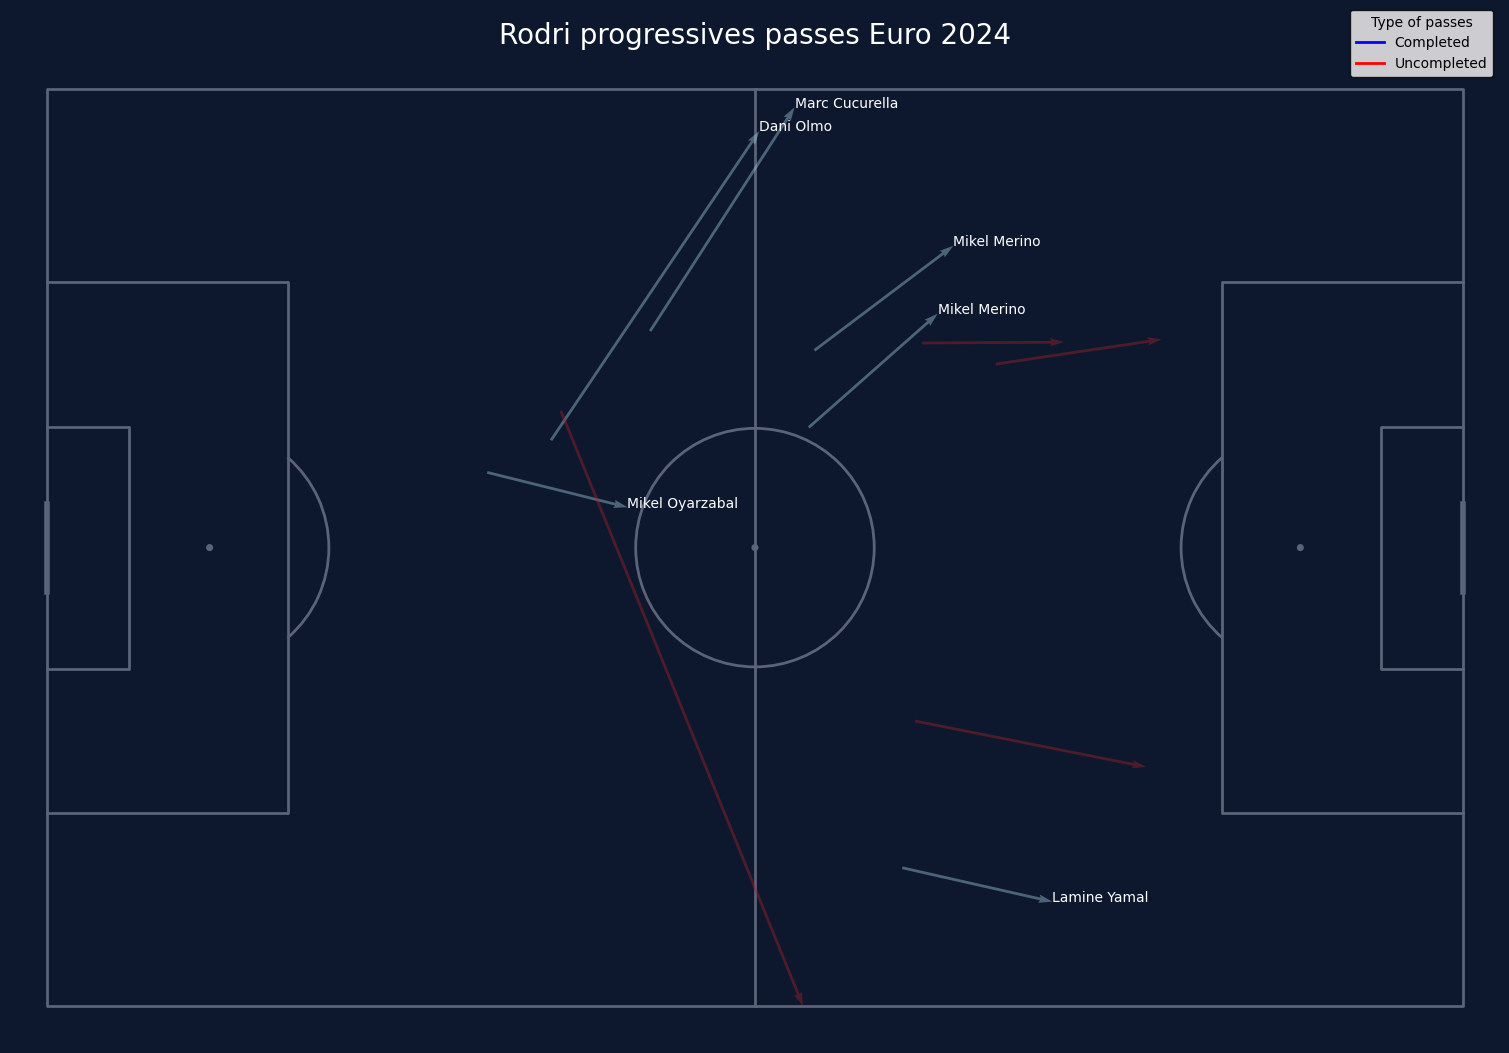

In [11]:
create_graph_pass(df_2024_pass, "Rodri", "Euro 2024", prog=True);

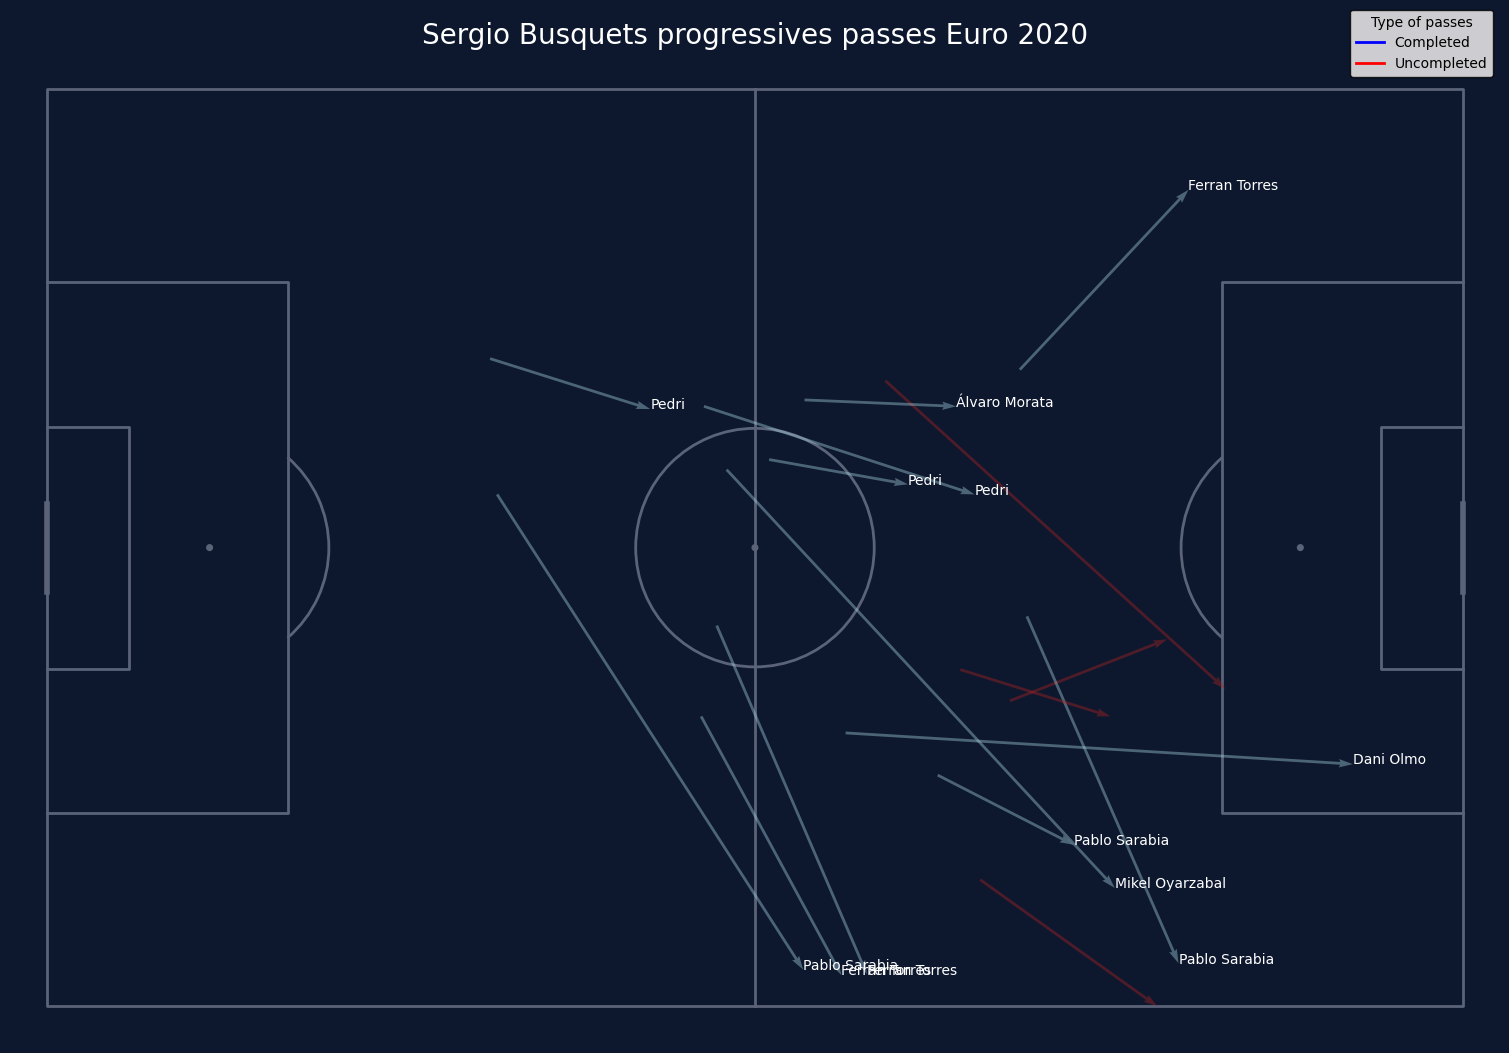

In [12]:
create_graph_pass(df_2020_pass, "Busquets", "Euro 2020", prog=True);

### Passing networks

<a class="anchor" id="network"></a>

In [13]:
# Fonction to create a visualisation of a passing network 

def network_graph(df, team, ax, pitch, col, flipped=False):

    df_pass = create_pass_df(df)
    df_pass_player = df_pass[df_pass["outcomeType"]=="Successful"]
    df_team = df[df["team"]==team].reset_index(drop=True)
    ind = df_team[df_team["type"]=='SubstitutionOff'].index[0]
    df_team = df_team.iloc[:ind]

    
    if flipped==True:
        player_pos = {player: [pitch.dim.right - df_pass_player[df_pass_player["player_name"]==player]["location_x"].mean(),pitch.dim.right - df_pass_player[df_pass_player["player_name"]==player]["location_y"].mean(), df_pass_player[df_pass_player["player_name"]==player]["isTouch"].count()]  for player in df_team["player_name"].unique()}
    else:
        player_pos = {player: [df_pass_player[df_pass_player["player_name"]==player]["location_x"].mean(),df_pass_player[df_pass_player["player_name"]==player]["location_y"].mean(), df_pass_player[df_pass_player["player_name"]==player]["isTouch"].count()]  for player in df_team["player_name"].unique()}

        
    
    player_receiver = {player : df_pass_player[df_pass_player["player_name"]==player][["receiver", "isTouch"]].groupby("receiver").count() for player in df_team["player_name"].unique()}

    color = np.array(mcol.to_rgba(col))
    
    for player in player_pos:   
        for receiver in player_receiver[player].index:
            if receiver in player_pos:
                ax.plot([player_pos[player][0], player_pos[receiver][0]], [player_pos[player][1], player_pos[receiver][1]],
                        linewidth=player_receiver[player].loc[receiver,"isTouch"],
                        color=color,  zorder=1, alpha=0.7)
                player_initial = ("").join([elt[0] for elt in receiver.split(" ")])
                ax.annotate(player_initial, [player_pos[receiver][0], player_pos[receiver][1]],c='#C4C4C4', va='center',
                              size=15, ha='center')
            
    
    for player in player_pos:
        ax.scatter(player_pos[player][0], player_pos[player][1], color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, marker="h", s=player_pos[player][2]*70)



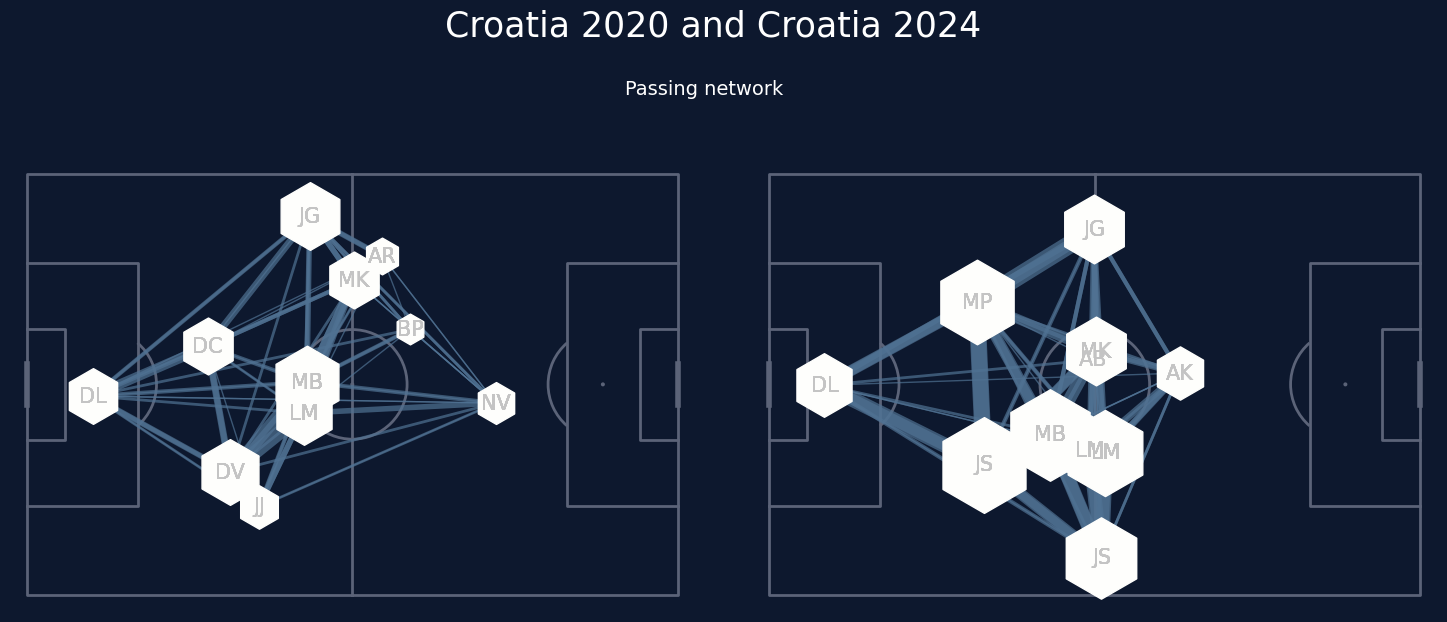

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.tight_layout()
fig.set_facecolor("#0D182E")

#title
title_team = "Croatia 2020 and Croatia 2024"

# plot variables
main_color = '#FBFAF5'
pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
pitch.draw(ax=ax[0])
pitch.draw(ax=ax[1])


network_graph(df_2020, "Croatia", ax[0], pitch, col='#507293', flipped=False)
network_graph(df_2024, "Croatia", ax[1], pitch, col='#507293', flipped=False)

plt.suptitle(title_team, fontsize=25, color="w")
plt.text(-10, 120, "Passing network", horizontalalignment='center', verticalalignment='center', color="w", fontsize=14);

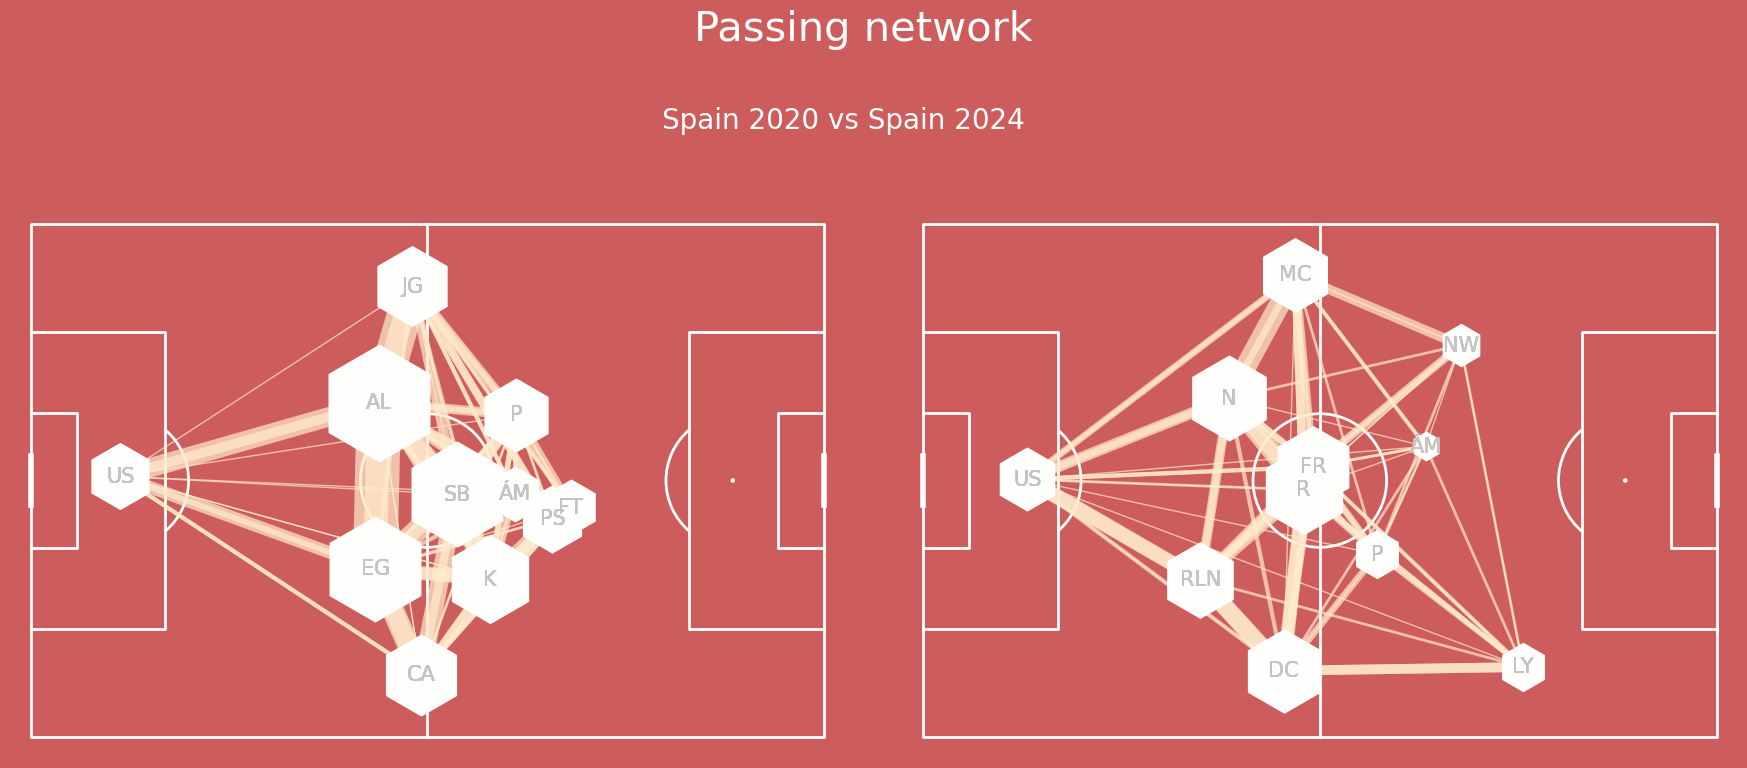

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.tight_layout()
fig.set_facecolor("indianred")

#title
title_team = "Passing network"

# plot variables
pitch = Pitch(pitch_type='opta', pitch_color='indianred', line_color='white')
pitch.draw(ax=ax[0])
pitch.draw(ax=ax[1])


network_graph(df_2020, "Spain", ax[0], flipped=False, col="blanchedalmond", pitch=pitch)
network_graph(df_2024, "Spain", ax[1], flipped=False, col="blanchedalmond", pitch=pitch)

plt.suptitle(title_team, fontsize=30, color="w")
plt.text(-10, 120, "Spain 2020 vs Spain 2024", horizontalalignment='center', verticalalignment='center', color="w", fontsize=20);

plt.savefig("Pics/passing network.png")


### Progressive passes

In [16]:
df_2024_pass_spain = df_2024_pass[df_2024_pass["team"]=="Spain"]
df_2020_pass_spain = df_2020_pass[df_2020_pass["team"]=="Spain"]

pass_count_24 = df_2024_pass_spain.count().iloc[0]
pass_prog_count_24 = df_2024_pass_spain["pass_prog"][df_2024_pass_spain["pass_prog"]==True].count()
ratio_24 = pass_prog_count_24 / pass_count_24

pass_count_20 = df_2020_pass_spain.count().iloc[0]
pass_prog_count_20 = df_2020_pass_spain["pass_prog"][df_2020_pass_spain["pass_prog"]==True].count()
ratio_20 = pass_prog_count_20 / pass_count_20


pd.DataFrame({"Spain 20": [pass_count_20, pass_prog_count_20, ratio_20],
              "Spain 24": [pass_count_24, pass_prog_count_24, ratio_24]})

,Spain 20,Spain 24
0,665.000000,486.000000
1,143.000000,115.000000
2,0.215038,0.236626


### Takeons

<a class="anchor" id="takeons"></a>

In [17]:
df_2024_takeon = create_takeon_df(df_2024)
df_2020_takeon = create_takeon_df(df_2020)

In [18]:
df_2024

,eventId,minute,team,player_name,period,type,outcomeType,isTouch,location_x,location_y,location_x_end,location_y_end,pass_angle,pass_length
0,3,0,Croatia,Luka Modric,FirstHalf,Pass,Successful,True,50.2,50.3,35.4,48.1,3.24,15.6
1,4,0,Croatia,Josip Sutalo,FirstHalf,Pass,Unsuccessful,True,36.5,47.7,77.0,100.0,0.71,56.1
2,4,0,Spain,Dani Carvajal,FirstHalf,Pass,Successful,True,28.4,0.0,33.8,6.7,0.75,7.8
3,5,0,Spain,Álvaro Morata,FirstHalf,Pass,Unsuccessful,True,33.8,6.7,43.7,22.9,0.81,15.1
4,6,0,Croatia,Josip Sutalo,FirstHalf,BallRecovery,Successful,False,56.1,72.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,820,94,Spain,Ferran Torres,SecondHalf,Pass,Successful,True,11.8,16.8,7.4,24.4,2.30,6.9
1521,831,94,Spain,Dani Carvajal,SecondHalf,TakeOn,Unsuccessful,True,7.8,21.6,NaN,NaN,NaN,NaN
1522,821,94,Spain,Dani Carvajal,SecondHalf,Foul,Successful,True,8.2,21.0,NaN,NaN,NaN,NaN
1523,896,94,Croatia,Ivan Perisic,SecondHalf,Foul,Unsuccessful,False,91.8,79.0,NaN,NaN,NaN,NaN


In [19]:
# Graph

#fig, ax = plt.subplots(figsize=(15, 7))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
#plt.tight_layout()
#pitch = Pitch(pitch_type='opta',pitch_color="indianred", line_color="white")
#pitch.draw(ax=ax)

#ax, p = beauty_pitch()
def graph_takeons(df, players, color, label):

    df_takeon = create_takeon_df(df)
    
    for player in players:

        
        df_player = df[df["player_name"].str.contains(player)]
        df_takeon_player = df_takeon[df_takeon["player_name"].str.contains(player)]
        freq = df_takeon_player.shape[0]
        if freq > 0:
            pos_mean_x = df_player["location_x"].mean()
            pos_mean_y = df_player["location_y"].mean()
            name = df_takeon_player["player_name"].iloc[0]
            ax.scatter(x=pos_mean_x, y=pos_mean_y, s=freq*50, color=color)
            ax.annotate(name, (pos_mean_x+1, pos_mean_y+1), color="white")

        else:
            freq = 0
            pos_mean_x = df_player["location_x"].mean()
            pos_mean_y = df_player["location_y"].mean()
            name = df_player["player_name"].iloc[0]
            ax.scatter(x=pos_mean_x, y=pos_mean_y, s=freq*50, color=color)
            ax.annotate(name, (pos_mean_x+1, pos_mean_y+1), color="white")
    
    ax.scatter(-10,-10,label=label,s=100, color=color)
    legend1 = ax.legend(loc='upper right', bbox_to_anchor=(0.8, 1.08))
    ax.add_artist(legend1)
    

#graph_takeons(df_2024,["Yamal", "Nico W"], "gray", "Euro 2024")
#graph_takeons(df_2020,["Ferran T", "Sarabia"], "lightgray", "Euro 2020")

#ax.set_title("All attempted takeons by spain wingers and their average position\nversus Croatia in Euro 2020 and Euro 2024", color="indianred",loc="left", fontsize=13)


# Define sizes and corresponding labels
#sizes = [50, 250]  # Example sizes
#labels = ["little", "many"]  # Example labels corresponding to sizes

# Create custom legend handles
#handles = [ax.scatter([], [], s=size, color='gray', alpha=0.6) for size in sizes]

# Create the secondary legend
#legend2 = ax.legend(handles, labels, loc='upper right', title="Number of Take-ons", bbox_to_anchor=(1, 1.08), scatterpoints=1)

# Add the secondary legend to the plot
#ax.add_artist(legend2);

Spain 2024 wingers took signigicantly more risk to attempt takeons than those in 2020

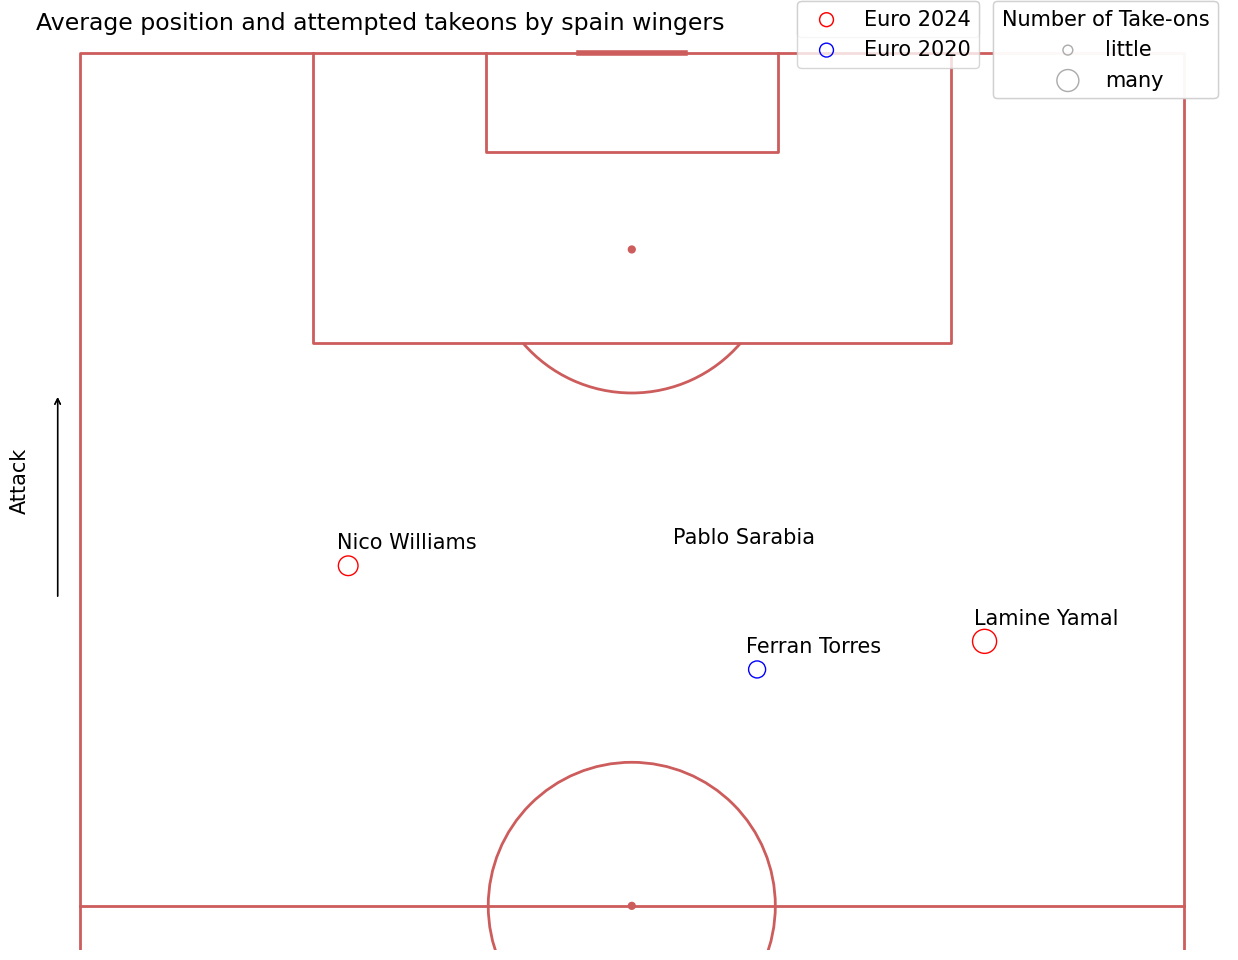

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.tight_layout()
pitch = VerticalPitch(pitch_type='opta',pitch_color="white", line_color="indianred", half=True)
pitch.draw(ax=ax)


def graph_takeons(df, players, color, label):

    df_takeon = create_takeon_df(df)
    
    for player in players:

        
        df_player = df[df["player_name"].str.contains(player)]
        df_takeon_player = df_takeon[df_takeon["player_name"].str.contains(player)]
        freq = df_takeon_player.shape[0]
        if freq > 0:
            pos_mean_y = df_player["location_x"].mean()
            pos_mean_x = df_player["location_y"].mean()
            name = df_takeon_player["player_name"].iloc[0]
            ax.scatter(x=pos_mean_x, y=pos_mean_y, s=freq*50, edgecolors=color, facecolors='none')
            ax.annotate(name, (pos_mean_x+1, pos_mean_y+1), color="black", size=15)

        else:
            freq = 0
            pos_mean_y = df_player["location_x"].mean()
            pos_mean_x = df_player["location_y"].mean()
            name = df_player["player_name"].iloc[0]
            ax.scatter(x=pos_mean_x, y=pos_mean_y, s=freq*50, color=color)
            ax.annotate(name, (pos_mean_x+1, pos_mean_y+1), color="black", size=15)
    
    ax.scatter(-10,-10,label=label,s=100, edgecolors=color, facecolors='none')
    legend1 = ax.legend(loc='upper right', bbox_to_anchor=(0.8, 1.02), fontsize=15)
    ax.add_artist(legend1)
    ax.annotate("", xy=(102, 80), xytext=(102, 68), arrowprops=dict(arrowstyle="->", color="black"))
    ax.set_ylabel("Attack", size=15)

graph_takeons(df_2024,["Yamal", "Nico W"], "red", "Euro 2024")
graph_takeons(df_2020,["Ferran T", "Sarabia"], "blue", "Euro 2020")

ax.set_title("Average position and attempted takeons by spain wingers", color="black",loc="left", fontsize=17, y=0.97)

# Define sizes and corresponding labels
sizes = [50, 250]  # Example sizes
labels = ["little", "many"]  # Example labels corresponding to sizes

# Create custom legend handles
handles = [ax.scatter([], [], s=size, edgecolors='gray', facecolors='none', alpha=0.6) for size in sizes]

# Create the secondary legend
legend2 = ax.legend(handles, labels, loc='upper right', title="Number of Take-ons", title_fontsize= 15, bbox_to_anchor=(1, 1.02), scatterpoints=1, fontsize=15)

# Add the secondary legend to the plot
ax.add_artist(legend2)

plt.savefig("Pics/wingers_takeon.png", dpi=900);

### Possession heatmap

<a class="anchor" id="possession"></a>

In [21]:
def create_df_poss(df, team):
    mask = (df["type"]=="Pass") | (df["type"]=="TakeOn") | (df["type"]=="MissedShots") | (df["type"]=="Goal")
    df = df[mask & (df["team"]==team)]
    df = df[["minute", "player_name", "type", "outcomeType","location_x", "location_y"]]
    return df

df_poss_spain_24 = create_df_poss(df_2024, "Spain")
df_poss_croatia_24 = create_df_poss(df_2024, "Croatia")
df_poss_spain_20 = create_df_poss(df_2020, "Spain")
df_poss_croatia_20 = create_df_poss(df_2020, "Croatia")

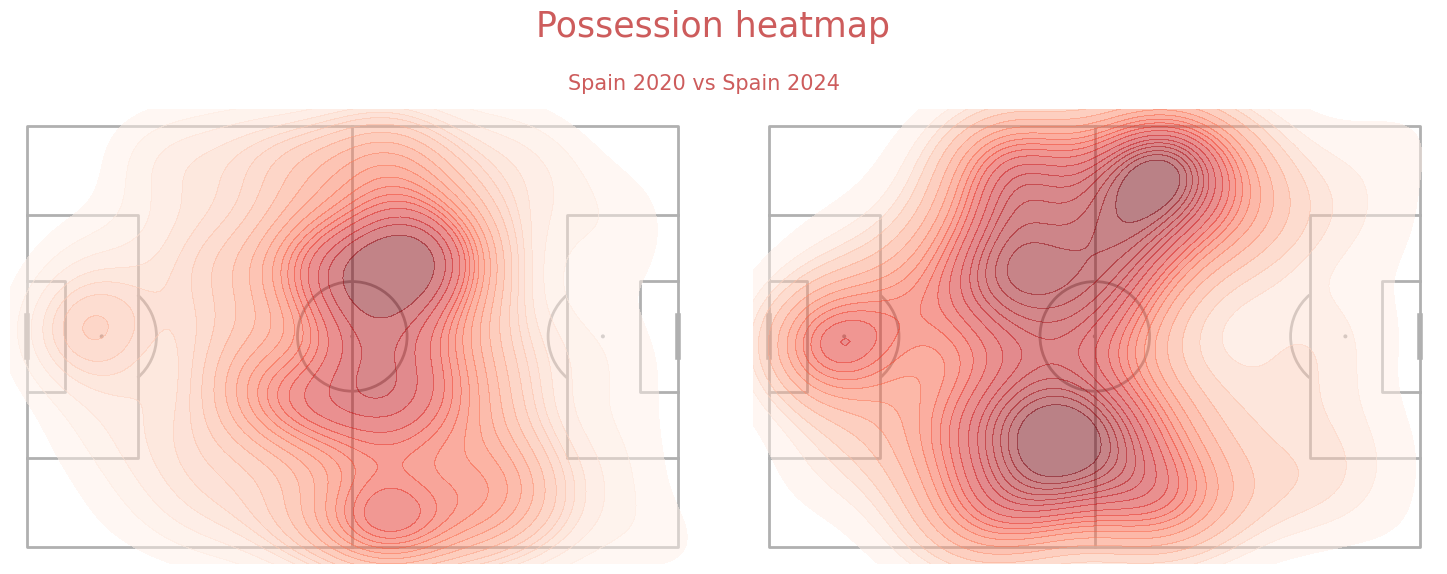

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15, 7))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.tight_layout()
plt.suptitle("Possession heatmap", fontsize=25, color="indianred")
plt.text(-10, 110, "Spain 2020 vs Spain 2024", horizontalalignment='center', verticalalignment='center', color="indianred", fontsize=15);

def heatmap(df_poss,axes):

    pitch = Pitch(pitch_type='opta')
    pitch.draw(ax=axes)
    
    kde = sns.kdeplot(x=df_poss['location_x'],
                          y=df_poss['location_y'],
                          fill = True,
                          shade_lowest=False,
                          alpha=.5,
                          n_levels=20,
                          cmap='Reds',
                          ax=axes
                         )
    axes.set_xlabel("")
    axes.set_ylabel("")


heatmap(df_poss_spain_20, ax[0])
heatmap(df_poss_spain_24, ax[1])

plt.savefig("Pics/possession heatmap.png")

### Defensive action

<a class="anchor" id="defensive"></a>

In [23]:
def create_df_def(df, team):
    mask = (df["type"]=="Interception") | (df["type"]=="Challenge") | (df["type"]=="Foul") | (df["type"]=="Tackle") | (df["type"]=="BlockedPass")
    df = df[mask & (df["team"]==team)]
    df = df[["minute", "player_name", "type", "outcomeType","location_x", "location_y"]]
    return df

df_def_spain_24 = create_df_def(df_2024, "Spain")
df_def_croatia_24 = create_df_def(df_2024, "Croatia")
df_def_spain_20 = create_df_def(df_2020, "Spain")
df_def_croatia_20 = create_df_def(df_2020, "Croatia")


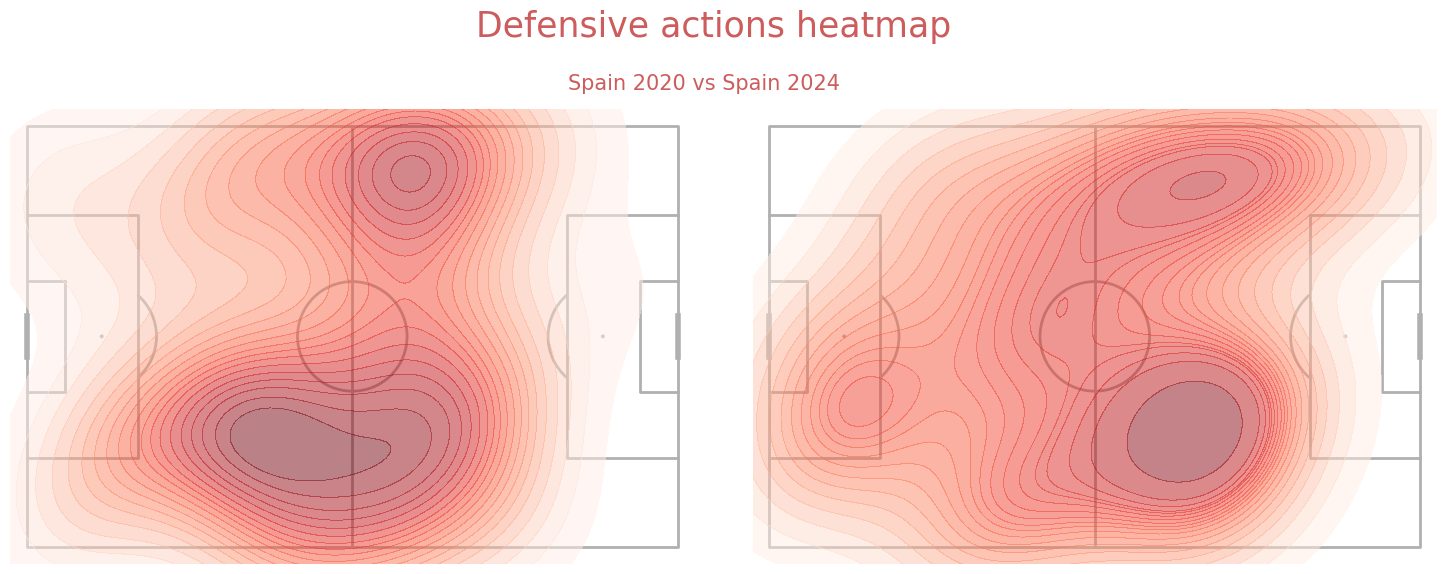

In [24]:
fig, ax = plt.subplots(1,2,figsize=(15, 7))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.tight_layout()
plt.suptitle("Defensive actions heatmap", fontsize=25, color="indianred")
plt.text(-10, 110, "Spain 2020 vs Spain 2024", horizontalalignment='center', verticalalignment='center', color="indianred", fontsize=15);


heatmap(df_def_spain_20, ax[0])
heatmap(df_def_spain_24, ax[1])

### Shots

<a class="anchor" id="shots"></a>

#### Spain

In [25]:
# import des xg

xg_24 = pd.read_csv("Data/xg_spain_2024.csv", index_col=0)
xg_24["minute"] = xg_24["minute"]-1

xg_20 = pd.read_csv("Data/xg_spain_2020.csv", index_col=0)
xg_20["minute"] = xg_20["minute"]-1

xg_24["player_name"] = xg_24["player_name"].str.replace("Fabián Ruiz Peña", "Fabián Ruiz")
xg_24["player_name"] = xg_24["player_name"].str.replace("Ferrán Torres", "Ferran Torres")
xg_24.loc[xg_24["minute"]==44,"minute"]=46

xg_20["player_name"] = xg_20["player_name"].str.replace("José Luis Gayà", "José Gayà")
xg_20["player_name"] = xg_20["player_name"].str.replace("Ferrán Torres", "Ferran Torres")
xg_20.loc[xg_20["minute"]==44,"minute"]=45
xg_20.loc[(xg_20["minute"]==89) & (xg_20["player_name"]=="Dani Olmo"),"minute"]=93
xg_20.loc[(xg_20["minute"]==89) & (xg_20["player_name"]=="Mikel Oyarzabal"),"minute"]=95


In [26]:
def create_df_shots(df, team):
    mask = (df["type"]=="MissedShots") | (df["type"]=="SavedShot") | (df["type"]=="Goal")
    df = df[mask & (df["team"]==team)]
    df = df[["minute", "player_name", "type", "outcomeType","location_x", "location_y"]]
    return df

df_shots_spain_24 = create_df_shots(df_2024, "Spain")
df_shots_croatia_24 = create_df_shots(df_2024, "Croatia")
df_shots_spain_20 = create_df_shots(df_2020, "Spain")
df_shots_croatia_20 = create_df_shots(df_2020, "Croatia")

In [27]:
df_shots_spain_24 = df_shots_spain_24.merge(xg_24, how="left", on=["minute", "player_name"])
df_shots_spain_24

,minute,player_name,type,outcomeType,location_x,location_y,team,xG,psXg,type_2
0,6,Álvaro Morata,SavedShot,Successful,77.9,37.0,Spain,0.05,0.19,Saved
1,14,Lamine Yamal,MissedShots,Successful,88.1,37.6,Spain,0.08,NaN,Off Target
2,28,Álvaro Morata,Goal,Successful,84.4,50.3,Spain,0.40,0.87,Goal
3,31,Fabián Ruiz,Goal,Successful,85.7,53.4,Spain,0.14,0.14,Goal
4,35,Robin Le Normand,MissedShots,Successful,93.9,51.5,Spain,0.15,NaN,Off Target
5,46,Dani Carvajal,Goal,Successful,94.8,46.4,Spain,0.50,0.65,Goal
6,51,Lamine Yamal,SavedShot,Successful,90.2,38.5,Spain,0.32,0.84,Saved
7,53,Álvaro Morata,MissedShots,Successful,97.4,57.9,Spain,0.24,NaN,Off Target
8,57,Lamine Yamal,SavedShot,Successful,74.7,41.3,Spain,0.07,NaN,Blocked
9,73,Dani Olmo,SavedShot,Successful,73.8,51.5,Spain,0.02,NaN,Blocked


In [28]:
df_shots_spain_20 = df_shots_spain_20.merge(xg_20, how="left", on=["minute", "player_name"])
df_shots_spain_20 = df_shots_spain_20.drop(4,axis=0).reset_index(drop=True)

In [29]:
shots_20 = df_shots_spain_20["xG"].count()
shots_24 = df_shots_spain_24["xG"].count()

xg_20 = df_shots_spain_20["xG"].sum()
xg_24 = df_shots_spain_24["xG"].sum()

xg_20_shot = round(xg_20 / shots_20, 2)
xg_24_shot = round(xg_24 / shots_24, 2)

psxg_20 = round(df_shots_spain_20["psXg"].sum(), 2)
psxg_24 = round(df_shots_spain_24["psXg"].sum(), 2)

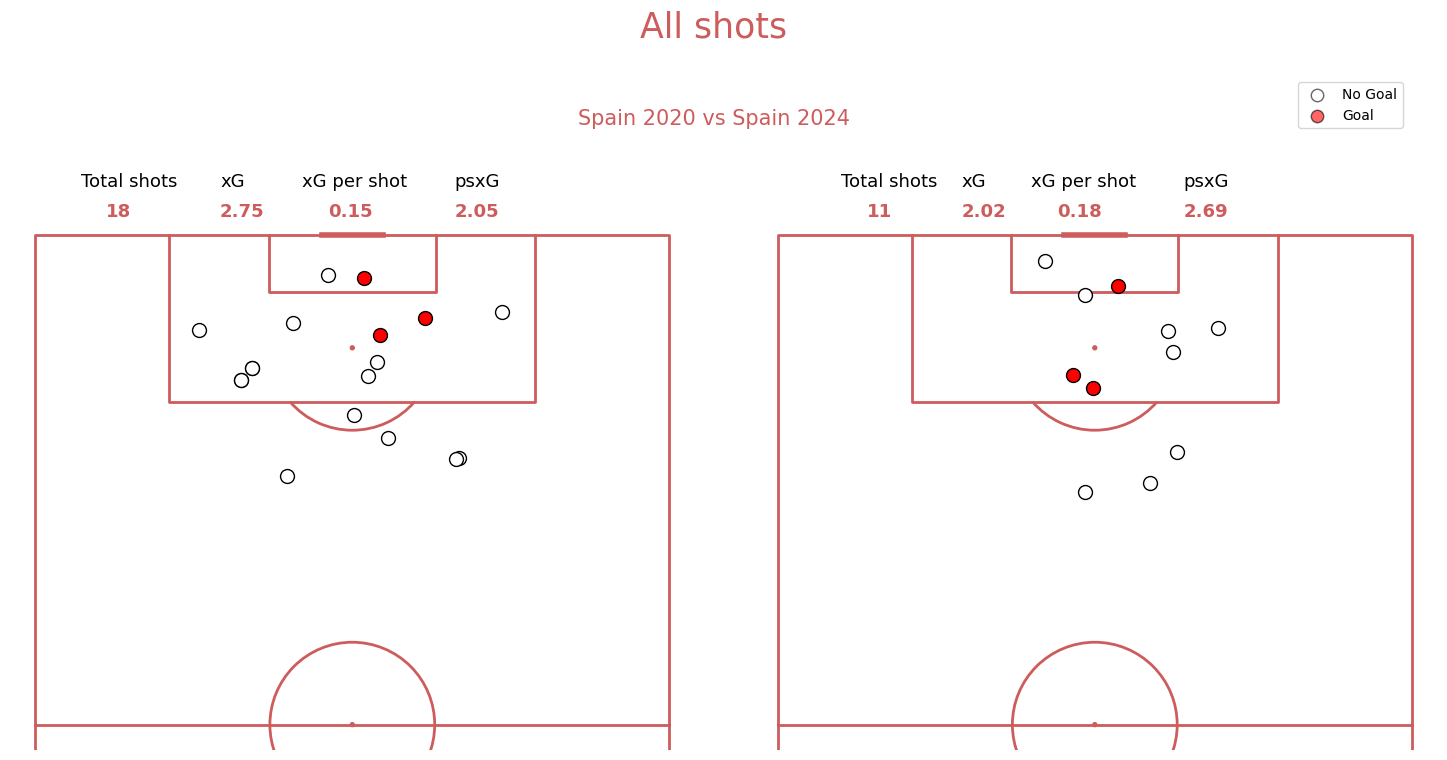

In [30]:
def shots_map(df1, df2,team, col, col2):

    fig, ax = plt.subplots(1,2,figsize=(15, 10))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.tight_layout()
    pitch = VerticalPitch(pitch_type='opta',pitch_color="white", line_color=col, half=True)
    pitch.draw(ax=ax[0])
    pitch.draw(ax=ax[1])

    plt.suptitle("All shots", fontsize=25, color=col)
    plt.text(110, 112, f"{team} 2020 vs {team} 2024", horizontalalignment='center', verticalalignment='center', color=col, fontsize=15)

    plt.text(210, 105, "Total shots",fontsize=13)
    plt.text(206, 102, shots_20,fontsize=13, color=col, fontweight="bold")

    plt.text(188, 105, "xG",fontsize=13)
    plt.text(188, 102, round(xg_20,2),fontsize=13, color=col, fontweight="bold")

    plt.text(175, 105, "xG per shot",fontsize=13)
    plt.text(171, 102, xg_20_shot,fontsize=13, color=col, fontweight="bold")

    plt.text(151, 105, "psxG",fontsize=13)
    plt.text(151, 102, psxg_20,fontsize=13, color=col, fontweight="bold")

    plt.text(90, 105, "Total shots",fontsize=13)
    plt.text(86, 102, shots_24,fontsize=13, color=col, fontweight="bold")

    plt.text(71, 105, "xG",fontsize=13)
    plt.text(71, 102, round(xg_24,2),fontsize=13, color=col, fontweight="bold")

    plt.text(60, 105, "xG per shot",fontsize=13)
    plt.text(56, 102, xg_24_shot,fontsize=13, color=col, fontweight="bold")

    plt.text(36, 105, "psxG",fontsize=13)
    plt.text(36, 102, psxg_24,fontsize=13, color=col, fontweight="bold")


    
    dict_col = {"Goal": col2, "SavedShot":"white", "MissedShots": "white"}
    
    for row in df1.iterrows():
        x = row[1]["location_y"]
        y = row[1]["location_x"]
        z = row[1]["xG"]
        ax[0].scatter(x=x, y=y, edgecolors="black", facecolors=dict_col[row[1]["type"]], s=100)
    
    
    for row in df2.iterrows():
        x = row[1]["location_y"]
        y = row[1]["location_x"]
        ax[1].scatter(x=x, y=y, edgecolors="black", facecolors=dict_col[row[1]["type"]], s=100)

    # Define sizes and corresponding labels
    colors = ["white", col2]  # Example sizes
    labels = ["No Goal", "Goal"]  # Example labels corresponding to sizes

    # Create custom legend handles
    handles = [ax[1].scatter([], [], s=80, edgecolors='black', facecolors=color, alpha=0.6) for color in colors]

    # Create the secondary legend
    legend2 = ax[1].legend(handles, labels, loc='upper right', title="", bbox_to_anchor=(0.96, 1.25), scatterpoints=1)



    return ax

shots_map(df_shots_spain_20, df_shots_spain_24, "Spain", "indianred", "red")

plt.savefig("Pics/all_shots_spain.png");

#### Croatia

In [31]:
# import des xg

xg_24 = pd.read_csv("Data/xg_croatia_2024.csv", index_col=0)
xg_24["minute"] = xg_24["minute"]-1

xg_20 = pd.read_csv("Data/xg_croatia_2020.csv", index_col=0)
xg_20["minute"] = xg_20["minute"]-1

xg_24["player_name"] = xg_24["player_name"].str.replace("Mateo Kovačić", "Mateo Kovacic")
xg_24["player_name"] = xg_24["player_name"].str.replace("Marcelo Brozović", "Marcelo Brozovic")
xg_24["player_name"] = xg_24["player_name"].str.replace("Joško Gvardiol", "Josko Gvardiol")
xg_24["player_name"] = xg_24["player_name"].str.replace("Andrej Kramarić", "Andrej Kramaric")
xg_24["player_name"] = xg_24["player_name"].str.replace("Josip Stanišić", "Josip Stanisic")
xg_24["player_name"] = xg_24["player_name"].str.replace("Bruno Petković (pen)", "Bruno Petkovic")
xg_24["player_name"] = xg_24["player_name"].str.replace("Ivan Perišić", "Ivan Perisic")
xg_24.loc[(xg_24["minute"]==44) & (xg_24["player_name"]=="Mateo Kovacic"),"minute"]=45
xg_24.loc[xg_24["minute"]==89,"minute"]=91

xg_20["player_name"] = xg_20["player_name"].str.replace("Mateo Kovačić", "Mateo Kovacic")
xg_20["player_name"] = xg_20["player_name"].str.replace("Marcelo Brozović", "Marcelo Brozovic")
xg_20["player_name"] = xg_20["player_name"].str.replace("Joško Gvardiol", "Josko Gvardiol")
xg_20["player_name"] = xg_20["player_name"].str.replace("Andrej Kramarić", "Andrej Kramaric")
xg_20["player_name"] = xg_20["player_name"].str.replace("Josip Stanišić", "Josip Stanisic")
xg_20["player_name"] = xg_20["player_name"].str.replace("Bruno Petković (pen)", "Bruno Petkovic")
xg_20["player_name"] = xg_20["player_name"].str.replace("Ivan Perišić", "Ivan Perisic")
xg_20["player_name"] = xg_20["player_name"].str.replace("Mario Pašalić", "Mario Pasalic")
xg_20["player_name"] = xg_20["player_name"].str.replace("Nikola Vlašić", "Nikola Vlasic")
xg_20["player_name"] = xg_20["player_name"].str.replace("Mislav Oršić", "Mislav Orsic")
xg_20["player_name"] = xg_20["player_name"].str.replace("Ante Rebić", "Ante Rebic")
xg_20.loc[xg_20["minute"]==89,"minute"]=91

In [32]:
df_shots_croatia_24 = df_shots_croatia_24.merge(xg_24, how="left", on=["minute", "player_name"])

In [33]:
df_shots_croatia_20 = df_shots_croatia_20.merge(xg_20, how="left", on=["minute", "player_name"])

In [34]:
shots_20 = df_shots_croatia_20["xG"].count()
shots_24 = df_shots_croatia_24["xG"].count()

xg_20 = df_shots_croatia_20["xG"].sum()
xg_24 = df_shots_croatia_24["xG"].sum()

xg_20_shot = round(xg_20 / shots_20, 2)
xg_24_shot = round(xg_24 / shots_24, 2)

psxg_20 = round(df_shots_croatia_20["psXg"].sum(), 2)
psxg_24 = round(df_shots_croatia_24["psXg"].sum(), 2)

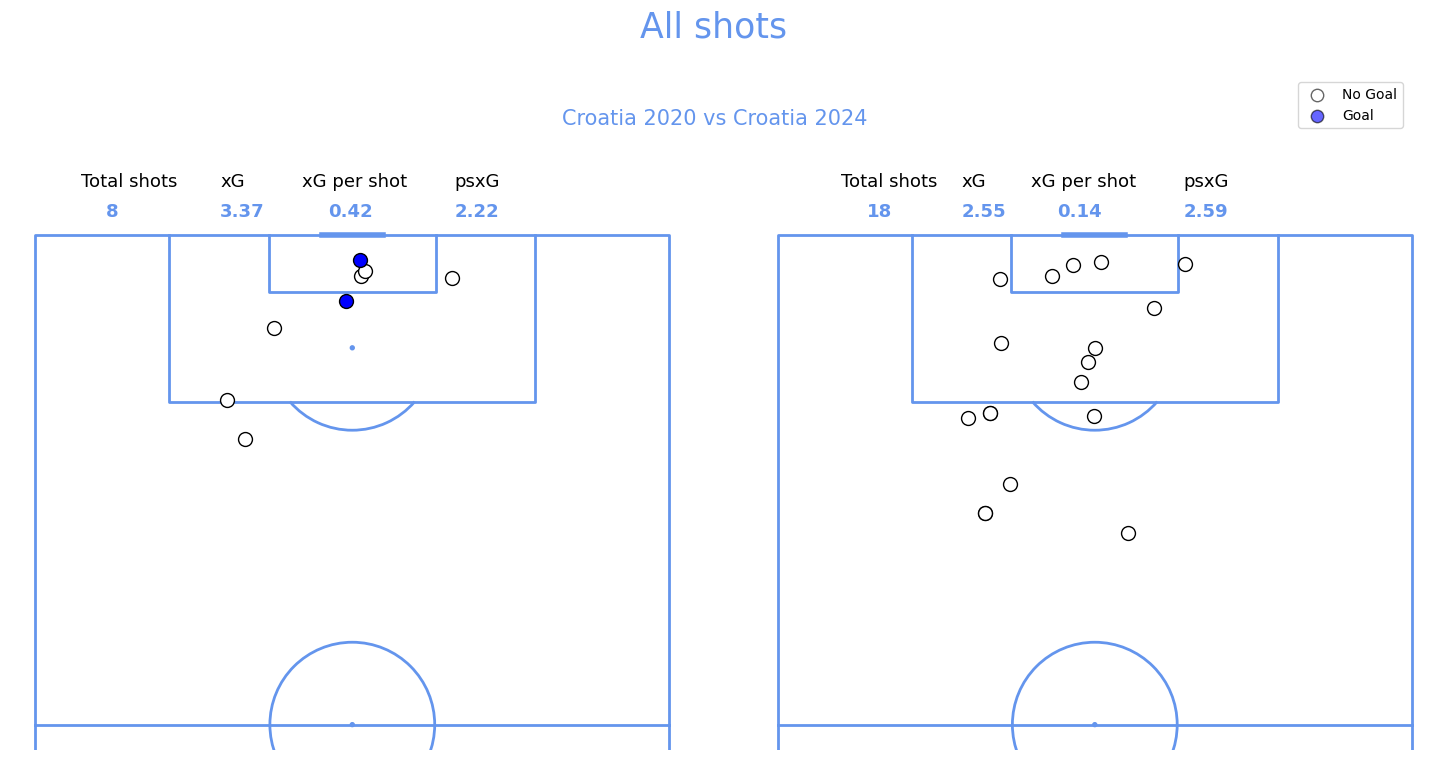

In [35]:
shots_map(df_shots_croatia_20, df_shots_croatia_24, "Croatia", "cornflowerblue", "blue");
plt.savefig("Pics/all_shots_croatia.png");

In [36]:
df_2024_pass.drop(columns=["arrow_color", "type", "period", "isTouch","eventId","pass_angle"])

,minute,team,player_name,outcomeType,location_x,location_y,location_x_end,location_y_end,pass_length,receiver,pass_prog
0,0,Croatia,Luka Modric,Successful,50.2,50.3,35.4,48.1,15.6,Josip Sutalo,False
1,0,Croatia,Josip Sutalo,Unsuccessful,36.5,47.7,77.0,100.0,56.1,None,True
2,0,Spain,Dani Carvajal,Successful,28.4,0.0,33.8,6.7,7.8,Álvaro Morata,False
3,0,Spain,Álvaro Morata,Unsuccessful,33.8,6.7,43.7,22.9,15.1,None,True
4,0,Croatia,Josip Sutalo,Successful,56.1,72.0,61.0,66.8,6.2,Luka Modric,False
...,...,...,...,...,...,...,...,...,...,...,...
1315,94,Croatia,Lovro Majer,Successful,69.5,85.0,86.3,96.0,19.2,Mario Pasalic,True
1316,94,Croatia,Mario Pasalic,Successful,86.5,95.5,80.7,88.8,7.6,Ivan Perisic,False
1317,94,Croatia,Ivan Perisic,Unsuccessful,86.9,93.0,87.2,89.7,2.3,None,False
1319,94,Spain,Ferran Torres,Successful,11.8,16.8,7.4,24.4,6.9,Dani Carvajal,False
